In [1]:
import sys

sys.path.append("..")

from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data

data = data[
    data["brand"].isin(["brand-35", "brand-14", "brand-15"])
] # Filtramos las 3 brands principales únicamente

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def regression_with_backward_elimination(
    data: pd.DataFrame,
    target: str = "volume.sales",
    alpha: float = 0.05,
    verbose: bool = False,
) -> tuple:
    """
    Realiza regresión OLS con backward elimination automática.

    Elimina automáticamente las variables no significativas (p-valor > alpha)
    del modelo de regresión.

    El modelo incluye:
    - Variables lineales: price, supermarket (dummy), variant (dummy), 
      pack_size (dummy), brand (dummy)
    - Interacciones solo entre price y brand (hasta segundo grado):
      price * brand, price**2, price**2 * brand

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame con los datos. Debe contener las columnas: price, supermarket,
        variant, pack.size, brand, y la columna target.
    target : str, default="volume.sales"
        Nombre de la columna objetivo (variable dependiente).
    alpha : float, default=0.05
        Nivel de significancia para eliminar variables. Variables con p-valor > alpha
        serán eliminadas.
    verbose : bool, default=False
        Si True, muestra el progreso de eliminación de variables.

    Returns:
    --------
    tuple:
        - model: Modelo final de statsmodels después de backward elimination
        - selected_vars: Lista de variables seleccionadas (nombres de columnas)
        - eliminated_vars: Lista de variables eliminadas durante el proceso

    Example:
    --------
    >>> model, selected, eliminated = regression_with_backward_elimination(data)
    >>> print(f"Variables seleccionadas: {len(selected)}")
    >>> print(f"Variables eliminadas: {len(eliminated)}")
    """
    # Hacer una copia para no modificar el DataFrame original
    data_work = data.copy()

    # Renombrar columnas para compatibilidad con patsy (puntos → guiones bajos)
    rename_dict = {
        "value.sales": "value_sales",
        "unit.sales": "unit_sales",
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    }

    # Solo renombrar las columnas que existen
    rename_dict = {k: v for k, v in rename_dict.items() if k in data_work.columns}
    data_work.rename(columns=rename_dict, inplace=True)

    # Actualizar el nombre del target si fue renombrado
    target_renamed = rename_dict.get(target, target)

    # Crear fórmula con:
    # - Términos lineales: price, supermarket, variant, pack_size, brand
    # - Interacciones solo entre price y brand (hasta segundo grado)
    formule = (
        f"{target_renamed} ~ price + C(supermarket) + C(variant) + C(pack_size) + "
        f"C(brand) + (price + C(brand)) ** 2"
    )

    # Crear matrices de diseño usando patsy
    y, X = patsy.dmatrices(formule, data=data_work, return_type="dataframe")
    
    # Guardar todas las variables iniciales
    initial_vars = set(X.columns.tolist())

    # Nombres posibles de constante/intercepto
    CONST_CANDIDATES = [c for c in ["const", "Intercept"] if c in X.columns]

    # Lista para rastrear variables eliminadas
    eliminated_vars = []

    # Backward elimination
    iteration = 0
    while True:
        iteration += 1

        # Ajustar el modelo OLS
        model = sm.OLS(y, X).fit()

        # Obtener p-valores excluyendo la constante/intercepto
        pvals = model.pvalues.copy()
        for c in CONST_CANDIDATES:
            if c in pvals.index:
                pvals = pvals.drop(c)

        # Si no hay más variables (solo queda la constante), terminar
        if pvals.empty:
            if verbose:
                print("No quedan variables para eliminar (solo constante).")
            break

        # Encontrar el p-valor máximo
        max_p = pvals.max()

        # Si el p-valor máximo es mayor que alpha, eliminar esa variable
        if max_p > alpha:
            worst_var = pvals.idxmax()  # Nombre de la variable con mayor p-valor

            if verbose:
                print(
                    f"Iteración {iteration}: Eliminando '{worst_var}' (p-valor = {max_p:.4f})"
                )

            # Eliminar la variable por nombre
            X = X.drop(columns=[worst_var])
            eliminated_vars.append(worst_var)
        else:
            # Todas las variables restantes son significativas
            if verbose:
                print(
                    f"Iteración {iteration}: Todas las variables restantes son significativas (p-valor ≤ {alpha})"
                )
            break

    # Ajustar el modelo final con las variables seleccionadas
    final_model = sm.OLS(y, X).fit()

    # Obtener las variables seleccionadas
    selected_vars = X.columns.tolist()

    if verbose:
        print(f"\nResumen:")
        print(f"  Variables iniciales: {len(initial_vars)}")
        print(f"  Variables seleccionadas: {len(selected_vars)}")
        print(f"  Variables eliminadas: {len(eliminated_vars)}")
        print(f"  R² ajustado: {final_model.rsquared_adj:.4f}")

    return final_model, selected_vars, eliminated_vars

In [3]:
model, selected_var, deleted_var = regression_with_backward_elimination(data, verbose=True)
print(model.summary())

Iteración 1: Eliminando 'price:C(brand)[T.brand-15]' (p-valor = 0.9778)
Iteración 2: Eliminando 'price' (p-valor = 0.0895)
Iteración 3: Todas las variables restantes son significativas (p-valor ≤ 0.05)

Resumen:
  Variables iniciales: 15
  Variables seleccionadas: 13
  Variables eliminadas: 2
  R² ajustado: 0.4307
                            OLS Regression Results                            
Dep. Variable:           volume_sales   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     215.4
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:49:57   Log-Likelihood:                -41082.
No. Observations:                3403   AIC:                         8.219e+04
Df Residuals:                    3390   BIC:                         8.227e+04
Df Model:                          12               

In [4]:
def x_train_exog_custom(train_data, selected_columns, model, target="volume.sales"):
    """
    Prepara las variables exógenas usando la misma fórmula que regression_with_backward_elimination.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Datos de entrenamiento
    selected_columns : list
        Lista de columnas seleccionadas por backward elimination
    model : statsmodels model
        Modelo ajustado
    target : str
        Nombre de la columna objetivo
        
    Returns:
    --------
    X_train_exog : pd.DataFrame
        DataFrame con las variables exógenas seleccionadas
    """
    train_data_for_patsy = train_data.copy()
    
    # Renombrar columnas para compatibilidad con patsy
    rename_dict = {
        "value.sales": "value_sales",
        "unit.sales": "unit_sales",
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    }
    rename_dict = {k: v for k, v in rename_dict.items() if k in train_data_for_patsy.columns}
    train_data_for_patsy.rename(columns=rename_dict, inplace=True)
    
    # Actualizar el nombre del target si fue renombrado
    target_renamed = rename_dict.get(target, target)
    
    # Usar la MISMA fórmula que en regression_with_backward_elimination
    formula = (
        f"{target_renamed} ~ price + C(supermarket) + C(variant) + C(pack_size) + "
        f"C(brand) + (price + C(brand)) ** 2"
    )
    
    # Crear la matriz de diseño
    y_design, X_design = patsy.dmatrices(
        formula, data=train_data_for_patsy, return_type="dataframe"
    )
    
    # Filtrar solo las columnas seleccionadas (excluyendo Intercept)
    selected_columns_no_intercept = [
        col for col in selected_columns if col != "Intercept" and col != "const"
    ]
    
    # Verificar que las columnas existen
    missing_cols = [col for col in selected_columns_no_intercept if col not in X_design.columns]
    if missing_cols:
        print(f"⚠️ Advertencia: Las siguientes columnas no se encontraron en X_design: {missing_cols}")
        print(f"Columnas disponibles en X_design: {list(X_design.columns)}")
        # Filtrar solo las que existen
        selected_columns_no_intercept = [
            col for col in selected_columns_no_intercept if col in X_design.columns
        ]
    
    X_train_exog = X_design[selected_columns_no_intercept]
    
    # Verificar que coinciden con el modelo
    model_features = list(model.params.index)
    exog_features = list(X_train_exog.columns)
    
    model_features_no_intercept = [f for f in model_features if f not in ["Intercept", "const"]]
    if set(model_features_no_intercept) == set(exog_features):
        print("✅ YES - All features match perfectly!")
    else:
        print("❌ NO - Features don't match")
        print(f"Model features (sin intercept): {sorted(model_features_no_intercept)}")
        print(f"Exog features: {sorted(exog_features)}")
        missing_in_exog = set(model_features_no_intercept) - set(exog_features)
        missing_in_model = set(exog_features) - set(model_features_no_intercept)
        if missing_in_exog:
            print(f"Missing in exog: {missing_in_exog}")
        if missing_in_model:
            print(f"Missing in model: {missing_in_model}")
    
    return X_train_exog

# Usar la nueva función
X_train_exog = x_train_exog_custom(data, selected_var, model)
print(f"\nShape de X_train_exog: {X_train_exog.shape}")
print(f"Columnas: {list(X_train_exog.columns)}")

✅ YES - All features match perfectly!

Shape de X_train_exog: (3403, 12)
Columnas: ['C(supermarket)[T.supermarket-B]', 'C(supermarket)[T.supermarket-C]', 'C(supermarket)[T.supermarket-D]', 'C(variant)[T.light]', 'C(variant)[T.standard]', 'C(variant)[T.vegan]', 'C(pack_size)[T.351 - 500 GR]', 'C(pack_size)[T.501 - 700 GR]', 'C(pack_size)[T.701 - 1000 GR]', 'C(brand)[T.brand-15]', 'C(brand)[T.brand-35]', 'price:C(brand)[T.brand-35]']


In [5]:
X_train_exogs = sa.x_train_exog(data, selected_var, model)
print(f"\nShape de X_train_exog: {X_train_exog.shape}")
print("Columnas:")
for col in X_train_exog.columns:
    print(col)


✅ YES - All features match perfectly!

Shape de X_train_exog: (3403, 12)
Columnas:
C(supermarket)[T.supermarket-B]
C(supermarket)[T.supermarket-C]
C(supermarket)[T.supermarket-D]
C(variant)[T.light]
C(variant)[T.standard]
C(variant)[T.vegan]
C(pack_size)[T.351 - 500 GR]
C(pack_size)[T.501 - 700 GR]
C(pack_size)[T.701 - 1000 GR]
C(brand)[T.brand-15]
C(brand)[T.brand-35]
price:C(brand)[T.brand-35]


In [6]:
#compare X_train_exog and X_train_exogs
print(X_train_exog.equals(X_train_exogs))

True


### Implementación 1: transformación **Logatítmica**

In [7]:
# ========== TRANSFORMACIÓN LOGARÍTMICA DE LA VARIABLE OBJETIVO ==========
# Verificar que volume.sales sea positiva para aplicar log
y_original = data['volume.sales'].copy()

print("📊 Verificación de datos para transformación logarítmica:")
print(f"   - Longitud de datos: {len(y_original)}")
print(f"   - Valor mínimo: {y_original.min():.6f}")
print(f"   - Valor máximo: {y_original.max():.6f}")
print(f"   - Valores <= 0: {(y_original <= 0).sum()}")
print(f"   - Media: {y_original.mean():.2f}")

# Decidir el método de transformación
if (y_original <= 0).any():
    # Si hay ceros o negativos, usar log(y + constante)
    min_positive = y_original[y_original > 0].min() if (y_original > 0).any() else 1.0
    constant = max(1.0, min_positive)
    y_log = np.log(y_original + constant)
    transformation_type = 'log_shift'
    transformation_constant = constant
    print(f"   ⚠️  Se detectaron valores <= 0. Usando log(y + {constant:.6f})")
else:
    # Si todos son positivos, usar log simple
    y_log = np.log(y_original)
    transformation_type = 'log'
    transformation_constant = 0.0
    print(f"   ✅ Todos los valores son positivos. Usando log(y)")

print(f"\n📈 Estadísticas después de la transformación:")
print(f"   - Media log: {y_log.mean():.6f}")
print(f"   - Desviación estándar log: {y_log.std():.6f}")
print(f"   - Tipo de transformación: {transformation_type}")

# Guardar información de la transformación para reversión futura
transformation_info = {
    'type': transformation_type,
    'constant': transformation_constant
}



📊 Verificación de datos para transformación logarítmica:
   - Longitud de datos: 3403
   - Valor mínimo: 0.165000
   - Valor máximo: 539900.600000
   - Valores <= 0: 0
   - Media: 36600.34
   ✅ Todos los valores son positivos. Usando log(y)

📈 Estadísticas después de la transformación:
   - Media log: 8.782770
   - Desviación estándar log: 3.106810
   - Tipo de transformación: log


In [8]:
print("=" * 60)
print("PROBANDO AUTO_ARIMA CON VARIABLES LIMPIAS")
print("=" * 60)

auto_arima_model_clean = auto_arima( 
    y=y_log,
    X=X_train_exog,  # Usar las variables limpias
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,  # Puedes aumentar esto si quieres probar más modelos
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  # Usar stepwise=True para ser más eficiente
    n_fits=50,  # Número de ajustes a probar
    information_criterion='aic'
)

PROBANDO AUTO_ARIMA CON VARIABLES LIMPIAS
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=18855.350, Time=0.51 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=17841.499, Time=85.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=184.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=18853.350, Time=3.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=18857.211, Time=0.99 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=135.72 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=164.70 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=17839.499, Time=44.10 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=101.39 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=96.65 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=17841.499, Time=65.45 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=17843.499, Time=76.74 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=17837.502, Time=34.59 sec
 ARIMA(0,0,0)(1,1,1)[12]             : AIC=inf,

-----------------Residues Analysis (White Noise) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.8760245563485528 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 1.4548666245845683e-178 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 7.04853588743164e-36 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
      lb_stat  lb_pvalue
10  6.167492      0.801 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 1.958625498564637 -- range(2.0)
------------------------------------------------------------------


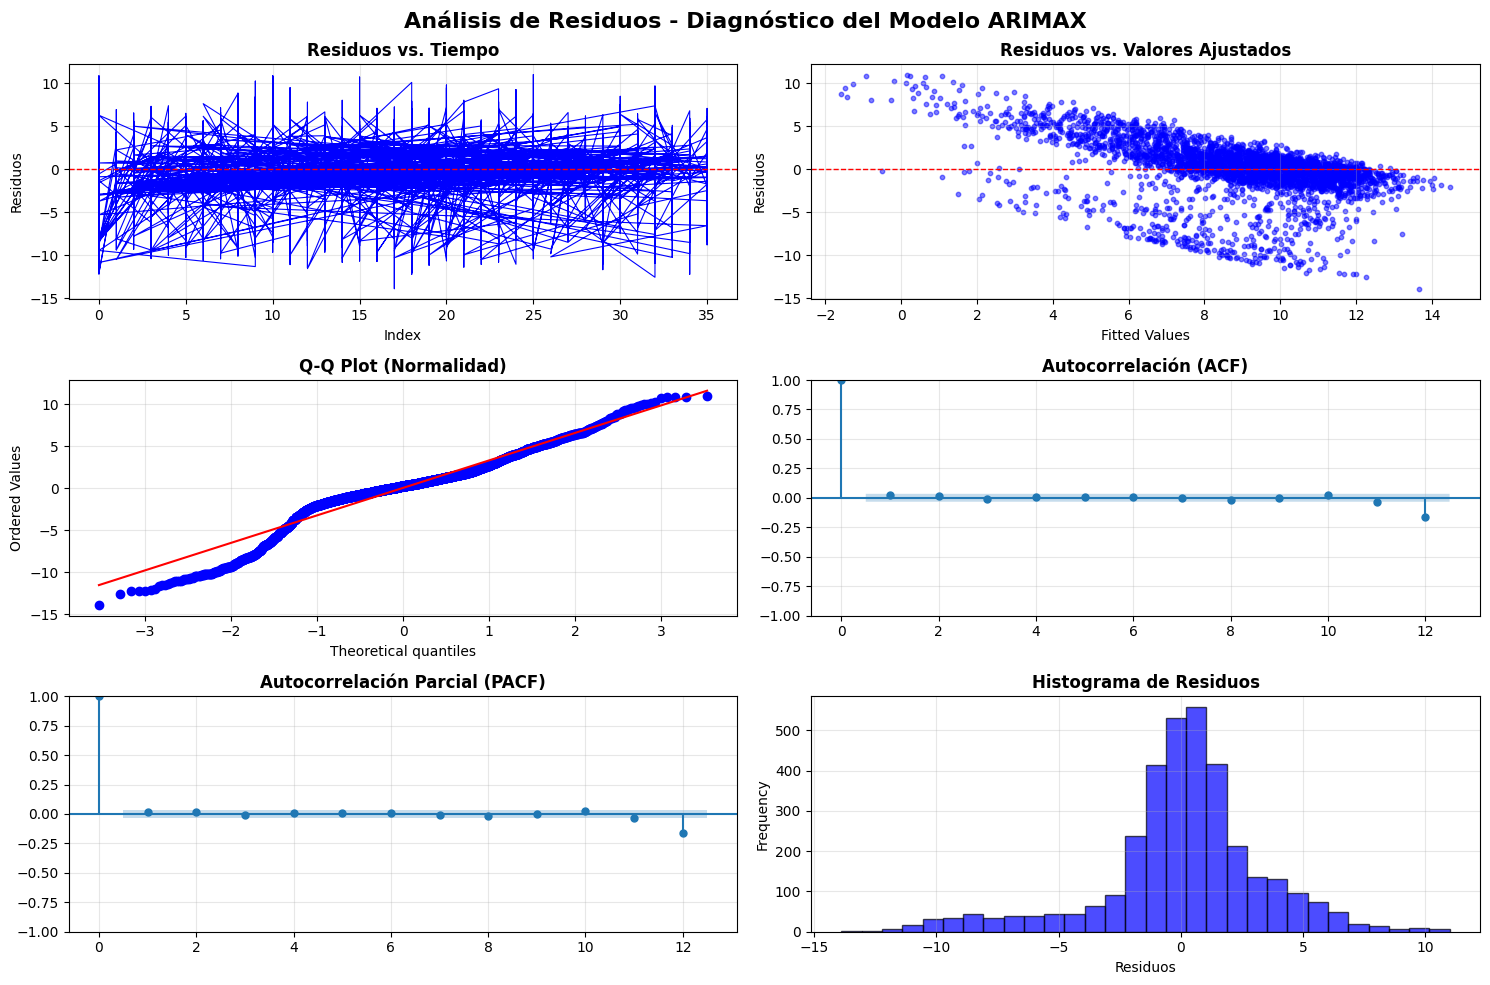

In [9]:
from scipy import stats
# Análisis de residuos

residuals = auto_arima_model_clean.arima_res_.resid

print("-----------------Residues Analysis (White Noise) -----------------")
sa.residual_white_noise_test(residuals)
print("------------------------------------------------------------------") 

# ========== GRÁFICO DE DIAGNÓSTICO DE RESIDUOS ==========

# Obtener residuos y valores ajustados
residuals = auto_arima_model_clean.arima_res_.resid
fitted_values = auto_arima_model_clean.arima_res_.fittedvalues

# Crear figura con 6 subplots (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Análisis de Residuos - Diagnóstico del Modelo ARIMAX', fontsize=16, fontweight='bold')

# 1. Residuos vs. Tiempo (arriba-izquierda)
axes[0, 0].plot(residuals, color='blue', linewidth=0.8)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuos vs. Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs. Valores Ajustados (arriba-derecha)
axes[0, 1].scatter(fitted_values, residuals, alpha=0.5, s=10, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_title('Residuos vs. Valores Ajustados', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (medio-izquierda)
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF (Autocorrelación) (medio-derecha)
plot_acf(residuals, lags=12, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 5. PACF (Autocorrelación Parcial) (abajo-izquierda)
plot_pacf(residuals, lags=12, ax=axes[2, 0], alpha=0.05, method='ywm')
axes[2, 0].set_title('Autocorrelación Parcial (PACF)', fontsize=12, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# 6. Histograma de Residuos (abajo-derecha)
axes[2, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[2, 1].set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Residuos')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Implementación 2: transformación **Box-Cox**

In [10]:
# ========== TRANSFORMACIÓN BOX-COX DE LA VARIABLE OBJETIVO ==========
# Verificar que volume.sales sea positiva para aplicar Box-Cox
y_original_bc = data['volume.sales'].copy()

print("📊 Verificación de datos para transformación Box-Cox:")
print(f"   - Longitud de datos: {len(y_original_bc)}")
print(f"   - Valor mínimo: {y_original_bc.min():.6f}")
print(f"   - Valor máximo: {y_original_bc.max():.6f}")
print(f"   - Valores <= 0: {(y_original_bc <= 0).sum()}")
print(f"   - Media: {y_original_bc.mean():.2f}")

# Box-Cox requiere valores estrictamente positivos
if (y_original_bc <= 0).any():
    # Si hay ceros o negativos, necesitamos hacer un shift
    min_positive = y_original_bc[y_original_bc > 0].min() if (y_original_bc > 0).any() else 1.0
    constant = max(1.0, min_positive)
    y_shifted = y_original_bc + constant
    print(f"   ⚠️  Se detectaron valores <= 0. Aplicando shift: y + {constant:.6f}")
else:
    y_shifted = y_original_bc.copy()
    constant = 0.0
    print(f"   ✅ Todos los valores son positivos. No se requiere shift")

# Aplicar transformación Box-Cox
# scipy.stats.boxcox encuentra el lambda óptimo y aplica la transformación
y_boxcox, lambda_optimal = stats.boxcox(y_shifted)

print(f"\n📈 Estadísticas después de la transformación Box-Cox:")
print(f"   - Lambda óptimo: {lambda_optimal:.6f}")
print(f"   - Media Box-Cox: {y_boxcox.mean():.6f}")
print(f"   - Desviación estándar Box-Cox: {y_boxcox.std():.6f}")
print(f"   - Constante de shift aplicada: {constant:.6f}")

# Guardar información de la transformación para reversión futura
boxcox_transformation_info = {
    'type': 'boxcox',
    'lambda': lambda_optimal,
    'constant': constant
}

# Nota: Para revertir la transformación Box-Cox:
# y_reversed = np.power(y_boxcox * lambda_optimal + 1, 1/lambda_optimal) - constant
# Si lambda_optimal == 0, entonces: y_reversed = np.exp(y_boxcox) - constant


📊 Verificación de datos para transformación Box-Cox:
   - Longitud de datos: 3403
   - Valor mínimo: 0.165000
   - Valor máximo: 539900.600000
   - Valores <= 0: 0
   - Media: 36600.34
   ✅ Todos los valores son positivos. No se requiere shift

📈 Estadísticas después de la transformación Box-Cox:
   - Lambda óptimo: 0.221782
   - Media Box-Cox: 32.753729
   - Desviación estándar Box-Cox: 16.377705
   - Constante de shift aplicada: 0.000000


In [11]:
print("=" * 60)
print("PROBANDO AUTO_ARIMA CON TRANSFORMACIÓN BOX-COX")
print("=" * 60)

auto_arima_model_boxcox = auto_arima( 
    y=y_boxcox,
    X=X_train_exog,  # Usar las variables limpias
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,  # Puedes aumentar esto si quieres probar más modelos
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  # Usar stepwise=True para ser más eficiente
    n_fits=50,  # Número de ajustes a probar
    information_criterion='aic'
)


PROBANDO AUTO_ARIMA CON TRANSFORMACIÓN BOX-COX
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=29273.054, Time=0.48 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=28272.393, Time=137.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=116.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=29271.054, Time=2.65 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=29273.788, Time=1.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=109.87 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=143.23 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=28270.887, Time=78.51 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=106.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=56.48 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=28272.458, Time=90.18 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=28274.364, Time=106.15 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=28268.878, Time=72.67 sec
 ARIMA(0,0,0)(1,1,1)[12]             : A

-----------------Residues Analysis (White Noise) - Box-Cox -----------------
[Heteroscedasticity Test] ARCH p-value: 0.7034787992778437 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 7.925822199046298e-38 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 1.6452917342222447e-20 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
      lb_stat  lb_pvalue
10  6.921181   0.732864 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 2.0073103032585897 -- range(2.0)
------------------------------------------------------------------


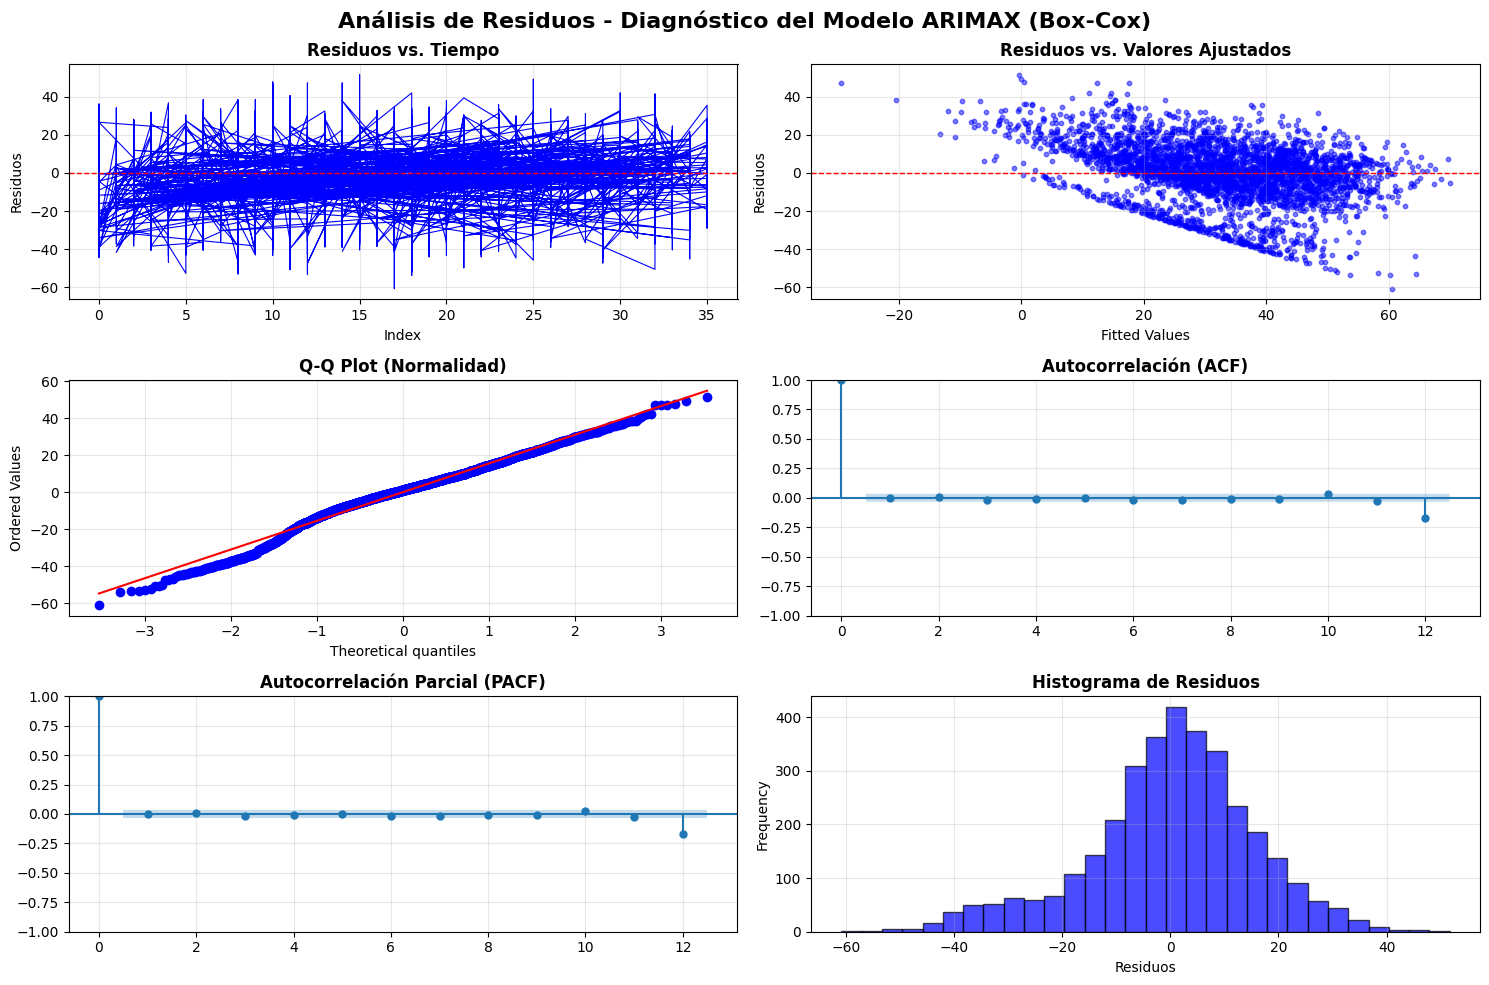

In [12]:
# Análisis de residuos para modelo Box-Cox

residuals_boxcox = auto_arima_model_boxcox.arima_res_.resid

print("-----------------Residues Analysis (White Noise) - Box-Cox -----------------")
sa.residual_white_noise_test(residuals_boxcox)
print("------------------------------------------------------------------") 

# ========== GRÁFICO DE DIAGNÓSTICO DE RESIDUOS ==========

# Obtener residuos y valores ajustados
residuals_boxcox = auto_arima_model_boxcox.arima_res_.resid
fitted_values_boxcox = auto_arima_model_boxcox.arima_res_.fittedvalues

# Crear figura con 6 subplots (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Análisis de Residuos - Diagnóstico del Modelo ARIMAX (Box-Cox)', fontsize=16, fontweight='bold')

# 1. Residuos vs. Tiempo (arriba-izquierda)
axes[0, 0].plot(residuals_boxcox, color='blue', linewidth=0.8)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuos vs. Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs. Valores Ajustados (arriba-derecha)
axes[0, 1].scatter(fitted_values_boxcox, residuals_boxcox, alpha=0.5, s=10, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_title('Residuos vs. Valores Ajustados', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (medio-izquierda)
stats.probplot(residuals_boxcox, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF (Autocorrelación) (medio-derecha)
plot_acf(residuals_boxcox, lags=12, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 5. PACF (Autocorrelación Parcial) (abajo-izquierda)
plot_pacf(residuals_boxcox, lags=12, ax=axes[2, 0], alpha=0.05, method='ywm')
axes[2, 0].set_title('Autocorrelación Parcial (PACF)', fontsize=12, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# 6. Histograma de Residuos (abajo-derecha)
axes[2, 1].hist(residuals_boxcox, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[2, 1].set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Residuos')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
